<a href="https://colab.research.google.com/github/alitariq1/vol-protected-ts-momentum/blob/main/vol_protected_ts_momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Acquisition

We begin by downloading daily historical price data for the SPY ETF using Yahoo Finance. The data spans from January 2015 to January 2024. We extract the closing price series for analysis and visualization.


[*********************100%***********************]  1 of 1 completed


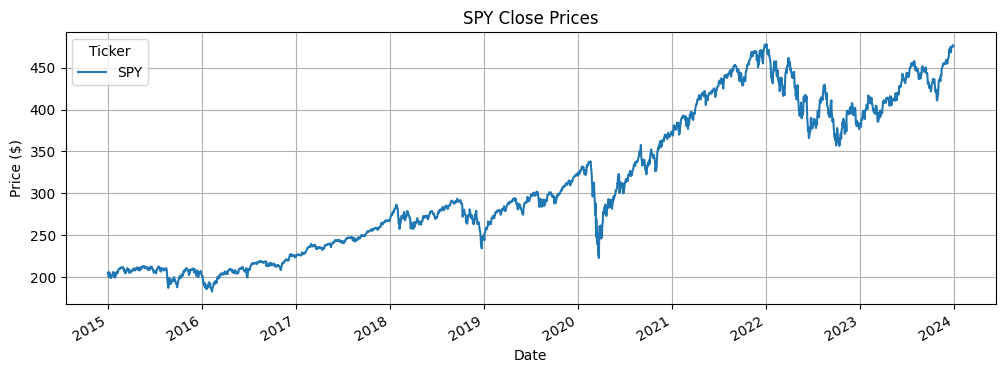

In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = yf.download("SPY", start="2015-01-01", end="2024-01-01", auto_adjust=False)
prices = data['Close']

prices.plot(figsize=(12, 4), title="SPY Close Prices", ylabel="Price ($)", xlabel="Date")
plt.grid(True)
plt.show()

## 2. Momentum Signal

We compute a 60-day time-series momentum by calculating the percentage change from 60 trading days ago. If the return is positive, the strategy takes a long position (signal = 1). If not, it stays in cash (signal = 0). This forms a binary momentum signal.

<Figure size 1200x400 with 0 Axes>

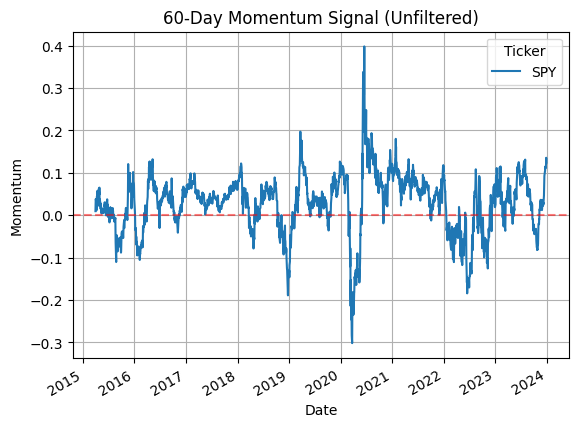

In [25]:
lookback = 60  # days
momentum = prices.pct_change(lookback)  # % return over 60 days
signal = (momentum > 0).astype(int)  # 1 = buy, 0 = cash

plt.figure(figsize=(12, 4))
momentum.plot(title="60-Day Momentum Signal (Unfiltered)", ylabel="Momentum", xlabel="Date")
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.grid(True)
plt.show()

## 3. Volatility Filter

To avoid exposure during turbulent periods, we compute a 20-day rolling standard deviation of daily returns. We then filter trades to only occur when volatility is below the 80th percentile.


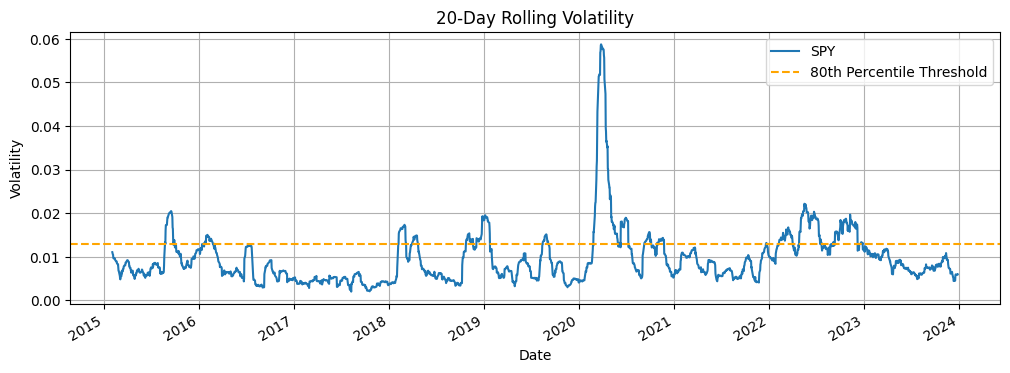

In [26]:
vol = prices.pct_change().rolling(20).std()

# Ensure vol is a Series, not DataFrame
if isinstance(vol, pd.DataFrame):
    vol = vol.iloc[:, 0]  # use first column

vol_threshold = float(vol.quantile(0.8))  # force float

fig, ax = plt.subplots(figsize=(12, 4))
vol.plot(ax=ax, title="20-Day Rolling Volatility", ylabel="Volatility", xlabel="Date")
ax.axhline(y=vol_threshold, color='orange', linestyle='--', label='80th Percentile Threshold')
ax.legend()
ax.grid(True)
plt.show()

## 4. Final Trading Signal

We multiply the momentum signal and the volatility filter to create a final binary signal. This signal is 1 only when both momentum is positive and volatility is low.

<Figure size 1200x400 with 0 Axes>

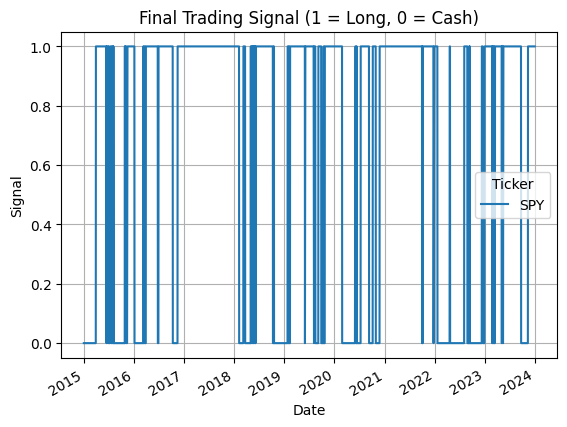

In [27]:
final_signal = signal * vol_filter

plt.figure(figsize=(12, 4))
final_signal.plot(title="Final Trading Signal (1 = Long, 0 = Cash)", ylabel="Signal", xlabel="Date")
plt.grid(True)
plt.show()

## 5. Strategy Returns and Cumulative Performance

We compute the daily returns of SPY and apply our trading signal (lagged by one day to avoid lookahead bias). The cumulative product of these returns gives the equity curve of the strategy.

<Figure size 1200x400 with 0 Axes>

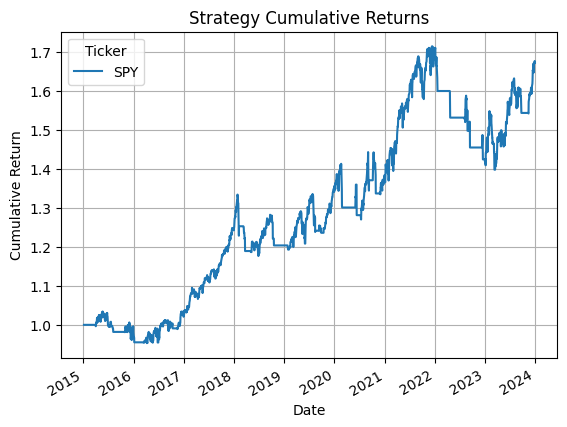

In [28]:
daily_returns = prices.pct_change()
strategy_returns = final_signal.shift(1) * daily_returns

cumulative = (strategy_returns + 1).cumprod()

plt.figure(figsize=(12, 4))
cumulative.plot(title="Strategy Cumulative Returns", ylabel="Cumulative Return", xlabel="Date")
plt.grid(True)
plt.show()

## 6. Drawdown Analysis

We compute the drawdown of the strategy to visualize risk and max loss from peak. Drawdown shows the % decline from the most recent equity peak.

<Figure size 1200x400 with 0 Axes>

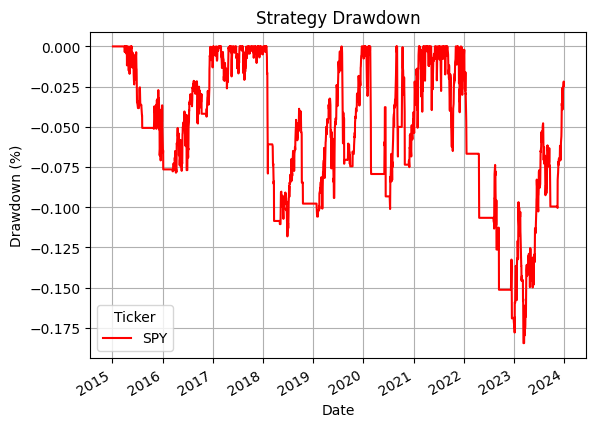

In [29]:
cumulative_max = cumulative.cummax()
drawdown = (cumulative - cumulative_max) / cumulative_max

plt.figure(figsize=(12, 4))
drawdown.plot(title="Strategy Drawdown", ylabel="Drawdown (%)", xlabel="Date", color='red')
plt.grid(True)
plt.show()

## 7. Sharpe Ratio

The Sharpe Ratio is used to measure risk-adjusted return. We compute the annualized Sharpe Ratio by dividing the mean daily return by its standard deviation and multiplying by the square root of 252 (trading days in a year).

In [30]:
strategy_returns = strategy_returns.squeeze()  # makes it Series if only 1 column
sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

print("Sharpe Ratio:", sharpe)

Sharpe Ratio: 0.6243571006651476
